In [85]:
%%html
<style>
div.text_cell_render {
    font-family: 'DejaVu Mono';
    border-left: 1.23rem solid black;
    padding: 2rem 0 2.3rem 2.3rem;
}
div.text_cell_render h1,
div.text_cell_render h2 {
    font-weight: 100;
}
</style>

# Bayesian Statistics

Bayesian Models are called *Probabilistic Models* because they are built using probabilities. We quantifiy uncertainty, so the answer we get is not a point estimate but rather a *distribution*.


## Bayesian Approch Steps

1. Establish a belief about data, including *Prior* and *Likelihood* functions.
2. Use data and probability to update our prior belief, check that our updated model agrees with the original data.
3. Update our view of the data based on the posterior model.

In [13]:
!pip install pymc3 arviz

     |████████████████████████████████| 869 kB 974 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 920 kB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 827 kB 991 kB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 228 kB 987 kB/s eta 0:00:01
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529948 sha256=ed4f95592919e0e3b15c83a246101815074b19c318d3930f4113ad13a6619343
  Stored in directory: /home/smooth/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [50]:
!pip install theano

     |████████████████████████████████| 2.8 MB 1.1 MB/s eta 0:00:01
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668094 sha256=b7b9c27aa1108cf61af09d94724a069aaba3ae081ed2cfc51b537b57e9d49fe8
  Stored in directory: /home/smooth/.cache/pip/wheels/84/cb/19/235b5b10d89b4621f685112f8762681570a9fa14dc1ce904d9
Successfully built theano


In [49]:
import warnings
import arviz as az
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from theano import shared
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline
warnings.filterwarnings('ignore')

In [26]:
url = 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv'
data = pd.read_csv(url)
data.shape

(25798, 9)

In [27]:
data = data.sample(frac=0.01, random_state=99)
data.shape

(258, 9)

In [28]:
data.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo
24835,2019-04-14 12:36:29,SEVILLA,MADRID,2019-04-16 07:15:00,2019-04-16 09:55:00,AVE,53.40,Turista,Promo
190,2019-04-15 19:09:34,MADRID,BARCELONA,2019-05-20 14:30:00,2019-05-20 17:21:00,AVE,85.10,Turista,Promo


In [30]:
data.isnull().sum() / len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.096899
train_class    0.000000
fare           0.000000
dtype: float64

9% of the price column are missing, we decided to fill them with mean of the respective fare types

In [31]:
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

In [32]:
data.isnull().sum() / len(data)

insert_date    0.0
origin         0.0
destination    0.0
start_date     0.0
end_date       0.0
train_type     0.0
price          0.0
train_class    0.0
fare           0.0
dtype: float64

## Gaussian Inference

Price variable follows somewhat a *Gaussian-Like distribution*. Then we assume that the ticket price follows a *Gaussian* but we do not know the mean $\mu$ or the standard deviation $\sigma$ so we have to set some priors for them.

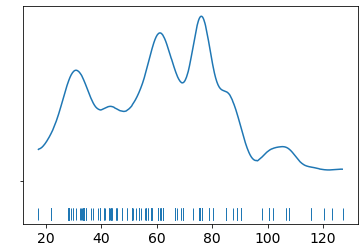

In [35]:
az.plot_kde(data['price'].values, rug=True);
plt.yticks([0], alpha=0);

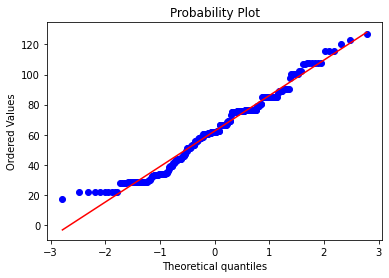

In [39]:
st.probplot(data.price, plot=plt);

## Modeling

We are now performing gaussian inference on the ticket price vector.

We need now to define our Model, summarized in the following steps:
1. Priors
    * Mean of the population $\mu$, from experience i know that a train ticket price can not be lower than 0 or higher than 300, so i define it wiht a *uniform distribution* boudend by 0 and 300
    * Standard deviation of the population $\sigma$, we know that it can only be positive, so we use a *Half-Normal distribution*.
2. Likelihood
    * y is a variable representing the data that comes from ${\mathcal {N}}(\mu ,\sigma ^{2})$
    * Draw 1000 posterior samples using NUTS sampling technique.

In [73]:
with pm.Model() as model:
    m = pm.Uniform('μ', lower=0, upper=300)
    s = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=m, sd=s, observed=data['price'].values)
    trace = pm.sample(1000, tune=1000, step=pm.NUTS(), cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


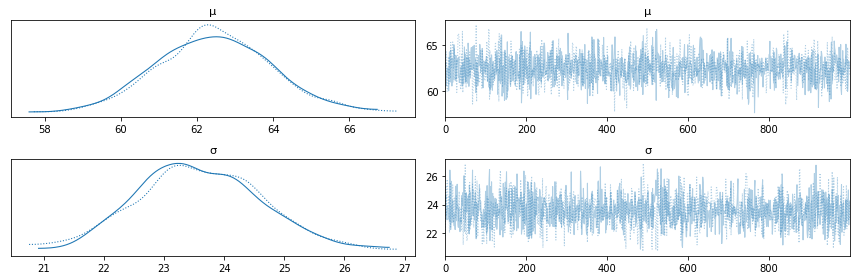

In [77]:
az.plot_trace(trace);
plt.tight_layout()

Got error No model on context stack. trying to find log_likelihood in translation.


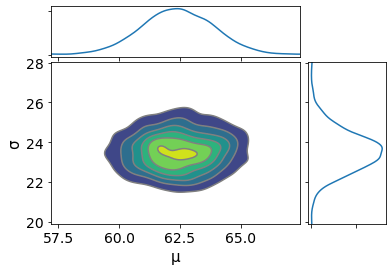

In [54]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [62]:
az.summary(trace_g)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,62.404,1.483,59.737,65.285,0.035,0.025,1822.0,1571.0,1.0
σ,23.550,1.000,21.762,25.504,0.023,0.017,1804.0,1433.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


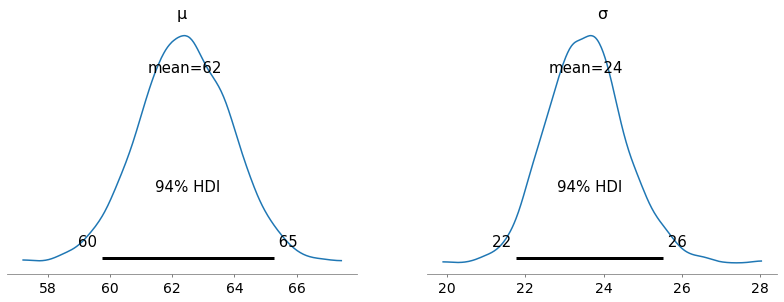

In [60]:
az.plot_posterior(trace_g);

## Notes

* Using *Bayesian Inference* we get the entire distribution of the values, unlike the *frequentism* where we get one point estimate.
* HDI or Highest density interval is not the same as *confidence intervals*, we can interpret as such that there is 94% probability the belief is between $60 and $65 for the mean ticket price. 
* ArviZ uses a default value of 94%, but you can set whatever value you want.

In [80]:
az.rhat(trace_g).values

Got error No model on context stack. trying to find log_likelihood in translation.


<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.002
    σ        float64 1.0>

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


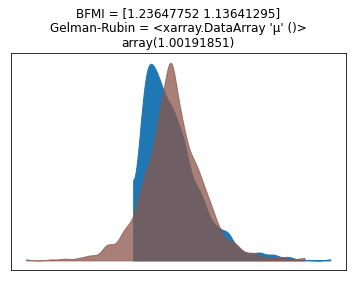

In [83]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in az.rhat(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));